In [2]:
import torch
import torch.nn as nn
import numpy as np

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
from models.model import MLP
from utils.losses import PartialLoss,CELoss
from utils.trainig_testing import train_and_evaluate,warm_up

In this case we will create 4 data structures so they contain the 4 Weak structures that support the 4 reconstruction matrices

In [3]:
rec_names = ['_pinv', '_opt', '_conv', '_optconv']
batch_size = 64
dataset_objects = []
weakener_objects = []

# Create dataset objects
for name in rec_names:
    dataset_name = 'Data' + name
    dataset = Torch_Dataset('mnist', batch_size=batch_size)
    dataset_objects.append(dataset)
    globals()[dataset_name] = dataset  # store dataset object in a variable with the corresponding name

# Create weakener objects
for name in rec_names:
    dataset_name = 'Data' + name
    weakener_name = 'Weak' + name
    weakener = Weakener(globals()[dataset_name].num_classes)
    weakener_objects.append(weakener)
    globals()[weakener_name] = weakener

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [8]:
rec_params = {'_pinv':{'optimize':False,'convex':False},
              '_opt':{'optimize':True,'convex':False},
              '_conv':{'optimize':False,'convex':True},
              '_optconv':{'optimize':True,'convex':True}}
for i,name in enumerate(rec_names):
    weakener_objects[i].generate_M('pll')
    _,train_y,_,_ =  globals()['Data'+name].get_data()
    #_,train_y,_,_ =  dataset_objects[i].get_data()
    _,_ = globals()['Weak'+name].generate_weak(train_y)
    #_,_ = weakener_objects[i].generate_weak(train_y)
    globals()['Weak'+name].virtual_matrix(convex=rec_params[name]['convex'],
                                       optimize=rec_params[name]['optimize'])
    #weakener_objects[i].virtual_matrix(convex=rec_params[name]['convex'],
    #                                   optimize=rec_params[name]['optimize'])
    globals()['Weak'+name].virtual_labels()
    #weakener_objects[i].virtual_labels()
    globals()['Data'+name].include_weak(globals()['Weak'+name].v)
    #dataset_objects[i].include_weak(weakener_objects[i].v)

In [9]:
#We will do the trainig for all the models
all_result = {}
all_model = {}
for i,name in enumerate(rec_names):
    trainloader, testloader = globals()['Data'+name].get_dataloader()
    mlp = MLP(globals()['Data'+name].num_features,[globals()['Data'+name].num_features],
              globals()['Data'+name].num_classes,dropout_p = 0.5, bn = True)
    optim = torch.optim.Adam(mlp.parameters(),lr=1e-3)
    loss = CELoss()
    print('\nTraining for'+ name +' reconstruction starts:\n')
    mlp, results = train_and_evaluate(mlp,trainloader,testloader,
                                      optimizer=optim,loss_fn=loss,num_epochs=5,sound=1)
    all_model[name] = {'model':mlp,'optimizer':optim,'loss':loss}
    all_result[name] = results



Training for_pinv reconstruction starts:

Epoch 1/5: Train Loss: 0.5286, Train Acc: 0.8284, Test Acc: 0.9036
Epoch 2/5: Train Loss: -0.1439, Train Acc: 0.8656, Test Acc: 0.9045
Epoch 3/5: Train Loss: -0.7665, Train Acc: 0.8643, Test Acc: 0.9067
Epoch 4/5: Train Loss: -1.6645, Train Acc: 0.8588, Test Acc: 0.9054
Epoch 5/5: Train Loss: -2.9869, Train Acc: 0.8549, Test Acc: 0.8944

Training for_opt reconstruction starts:

Epoch 1/5: Train Loss: 0.5526, Train Acc: 0.8308, Test Acc: 0.8950
Epoch 2/5: Train Loss: -0.1688, Train Acc: 0.8635, Test Acc: 0.8990
Epoch 3/5: Train Loss: -0.7525, Train Acc: 0.8616, Test Acc: 0.9038
Epoch 4/5: Train Loss: -1.7183, Train Acc: 0.8582, Test Acc: 0.8945
Epoch 5/5: Train Loss: -2.9206, Train Acc: 0.8523, Test Acc: 0.8975

Training for_conv reconstruction starts:

Epoch 1/5: Train Loss: 0.6088, Train Acc: 0.8321, Test Acc: 0.9146
Epoch 2/5: Train Loss: -0.0131, Train Acc: 0.8695, Test Acc: 0.9129
Epoch 3/5: Train Loss: -0.5306, Train Acc: 0.8727, Test Acc

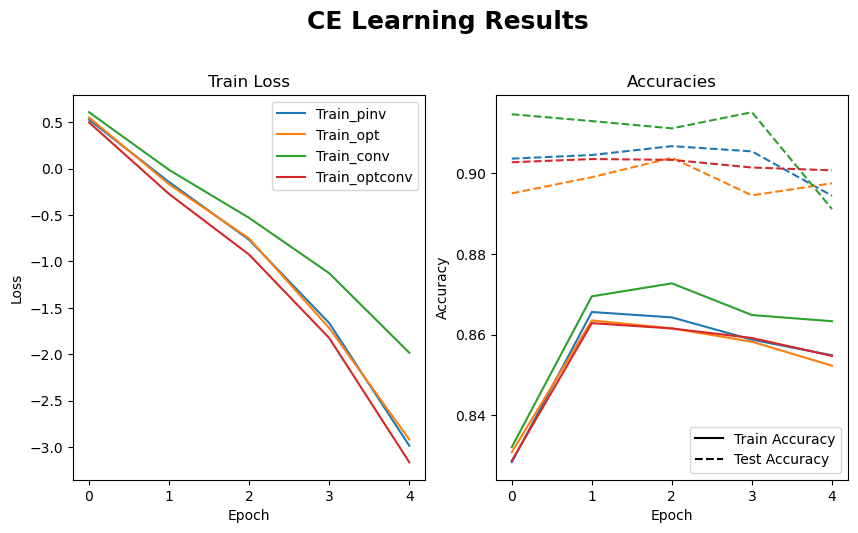

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

tableau_palette = mcolors.TABLEAU_COLORS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = list(tableau_palette.values())

# Plot the first subplot (Train Loss)
for i,name in enumerate(rec_names):
    ax1.plot(all_result[name]['train_loss'],label='Train'+name,color=colors[i])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Train Loss')


# Plot the second subplot (Accuracies)
for i,name in enumerate(rec_names):
    ax2.plot(all_result[name]['train_acc'], label='Train Accuracy'+name,
             color=colors[i])
    ax2.plot(all_result[name]['test_acc'], label='Test Accuracy'+name,
             color=colors[i],linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
#ax2.legend()
legend_elements = [Line2D([0], [0], linestyle='-', color='black', label='Train Accuracy'),
                   Line2D([0], [0], linestyle='--', color='black', label='Test Accuracy')]
ax2.legend(handles=legend_elements)

fig.suptitle('CE Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()